# Demand Forecasting using LSTM
---
## Problem Statement ~
>Every retailer must stay on top of planning activity to stand the demand of goods based on needs. A highly accurate demand forecast is the only way retailers can predict which goods are needed for each store location. This will also ensure high availability for customers while maintaining minimal stock risk and support capacity management, store staff labour force planning, etc. <br>
The project will use LSTM, which is very suitable for handling time-series data and widely
used for forecasting purposes.

## Dataset
> The dataset for this project is available on Kaggle. 

**Link:** https://www.kaggle.com/c/demand-forecasting-kernels-only/data?select=train.csv

### Table of Contents¶
#### 1. Environment Setup
#### 2. Dataset Gathering
#### 3. Exploratory Data Analysis
#### 4. Dataset Preprocessing
#### 5. Model Evaluation
#### 6. Performance Measurement

# 1. Environment Setup:
---
> In this step, we have installed and imported all neccessary libraries required to proceed with the solution to the given problem statement.

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 2. Dataset Gathering
---
> In this step, we have gathered the dataset from kaggle and have verified its integrity.

In [2]:
train = pd.read_csv("../input/demand-forecasting-kernels-only/train.csv")
test =  pd.read_csv("../input/demand-forecasting-kernels-only/test.csv")

# 3. Exploratory Data Analysis
---
> In this step, we took a deeper look at the data, and checked if the data is properly gathered in the previous steps.

In [3]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [7]:
print('Min date from test set: %s' % train['date'].min())
print('Max date from test set: %s' % train['date'].max())
import datetime
lag_size = len(test['date'].unique())
print('Forecast lag size: ', lag_size)

Min date from test set: 2013-01-01
Max date from test set: 2017-12-31
Forecast lag size:  90


In [8]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
print(daily_sales)

            date  sales
0     2013-01-01  13696
1     2013-01-02  13678
2     2013-01-03  14488
3     2013-01-04  15677
4     2013-01-05  16237
...          ...    ...
1821  2017-12-27  20378
1822  2017-12-28  21885
1823  2017-12-29  23535
1824  2017-12-30  24988
1825  2017-12-31  26420

[1826 rows x 2 columns]


In [9]:
daily_sales=daily_sales.reset_index()['sales']
print(daily_sales)

0       13696
1       13678
2       14488
3       15677
4       16237
        ...  
1821    20378
1822    21885
1823    23535
1824    24988
1825    26420
Name: sales, Length: 1826, dtype: int64


#### Overall Daily Sales
> In this step, we have aggregated the sales value and grouped it by date before finally plotting it.

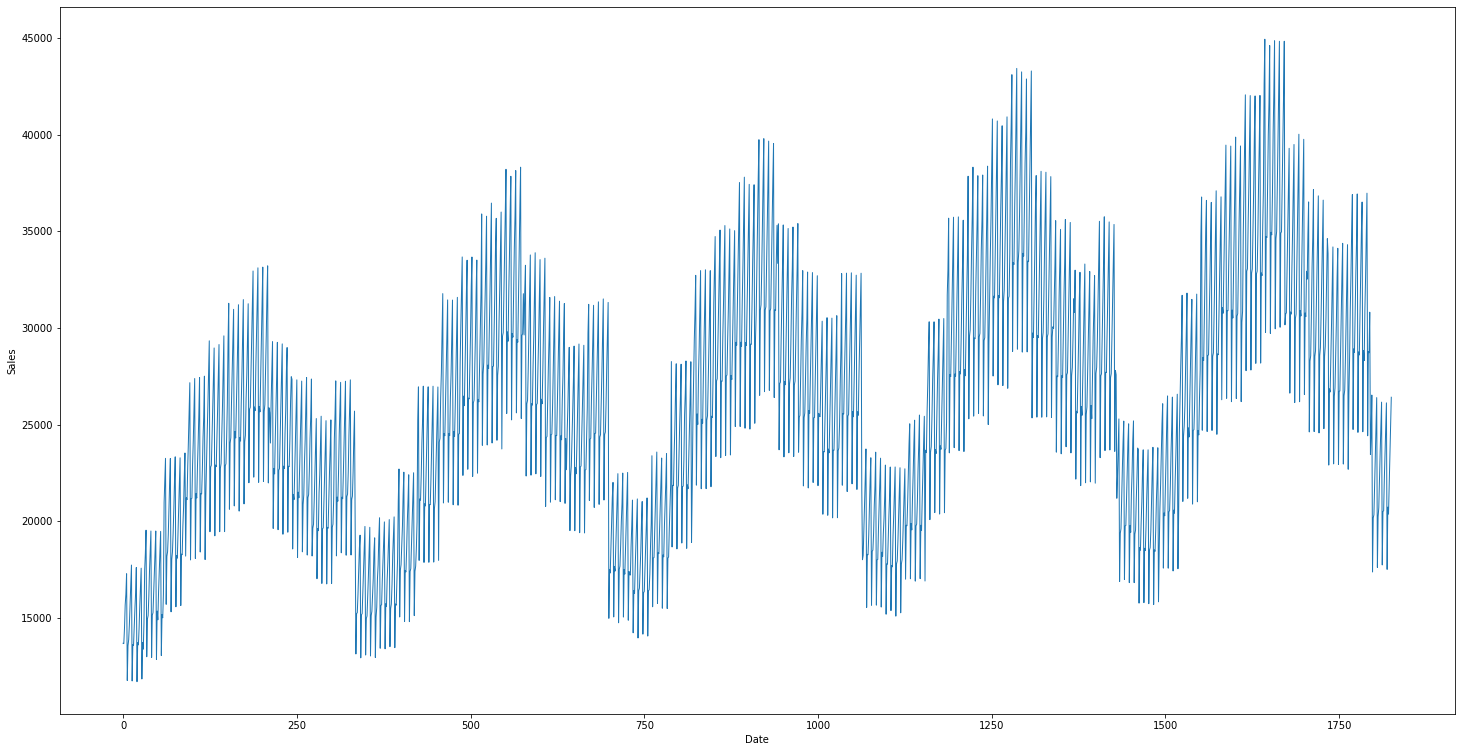

In [10]:
plt.figure(figsize=(25,13))
plt.plot(daily_sales, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#### Daily Sales by Store
> In this step, we have taken sub-tables for each store, and then group their sales values by the date. Finally, we have plotted the graph for the sales value for each individual store.

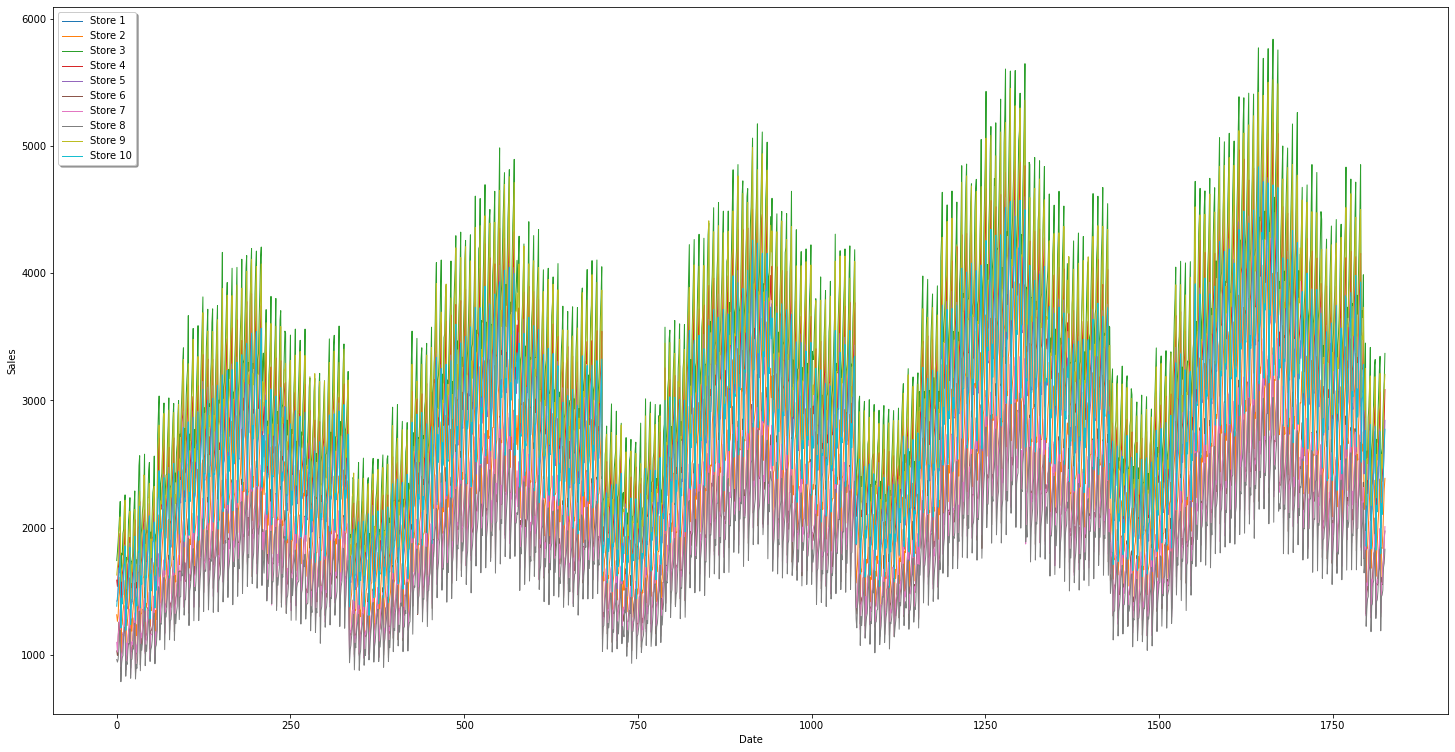

In [11]:
plt.figure(figsize=(25,13))
legend = []
for i in range(10):
    store_sales=train.loc[train['store'] == i]
    store_sales=store_sales.groupby('date', as_index=False)['sales'].sum()
    store_sales=store_sales.reset_index()['sales']
    plt.plot(store_sales, linewidth=1)    
    legend.append(('Store '+str(i+1)))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(legend, loc='upper left', ncol=1, fancybox=True, shadow=True)
plt.show()

#### Daily Sales by Item
> In this step, we have taken sub-tables for each item, and then group their sales values by the date. Finally, we have plotted the graph for the sales value for each individual item.

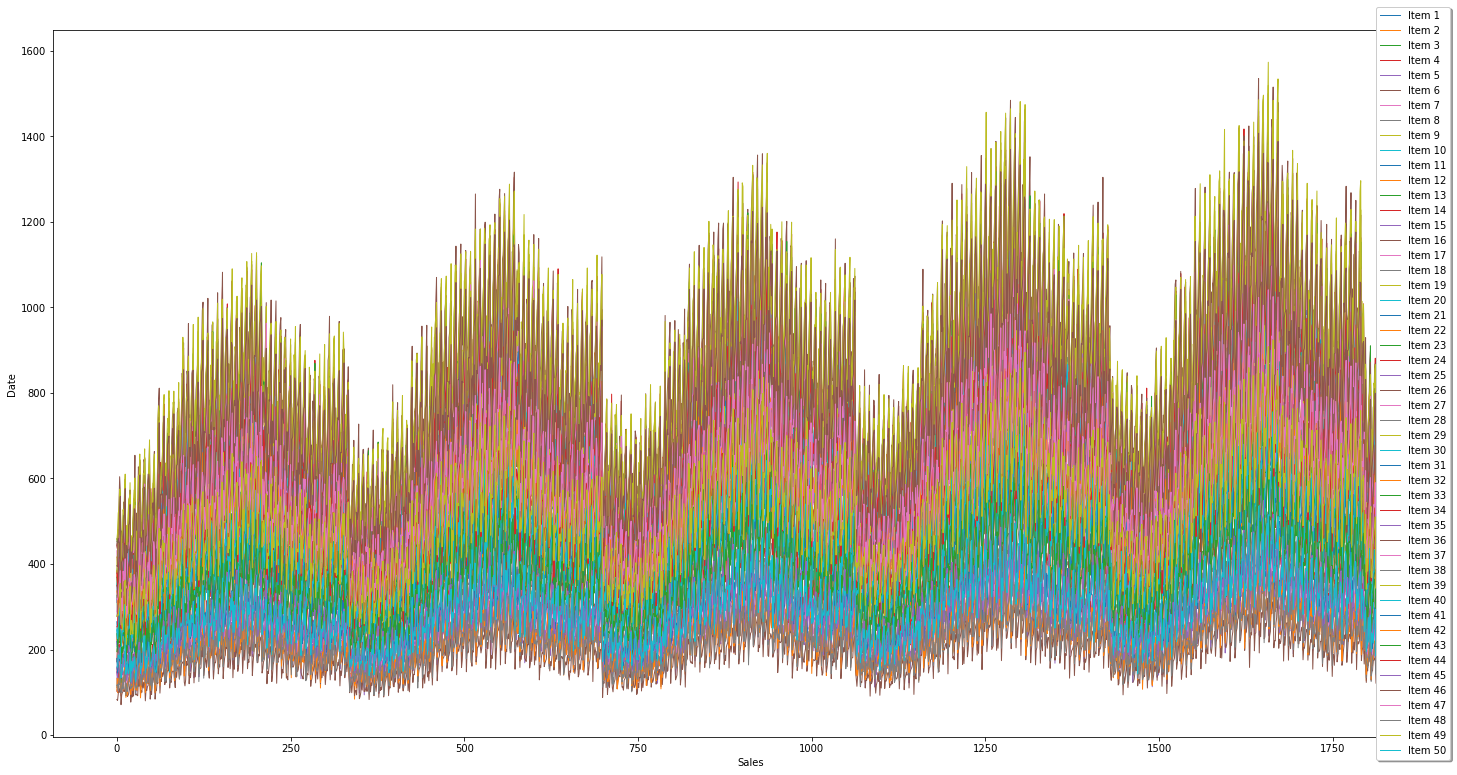

In [12]:
plt.figure(figsize=(25,13))
legend = []
for i in range(50):
    item_sales=train.loc[train['item'] == i]
    item_sales=item_sales.groupby('date', as_index=False)['sales'].sum()
    item_sales=item_sales.reset_index()['sales']
    plt.plot(item_sales, linewidth=1)    
    legend.append(('Item '+str(i+1)))
plt.xlabel('Sales')
plt.ylabel('Date')
plt.legend(legend, loc='upper right', ncol=1, bbox_to_anchor=[1.005, 1.04], fancybox=True, shadow=True)
plt.show()

# 4. Data Preprocessing:
---
> In this step, we have cleaned the data thus obtained for the previous steps before splitting them into training and testing datasets.

#### Sub-sampling training set to get only the last year of data and reduce training time
> In this step, we have sub-sampled the training set to only look at last year's data to reduce our training time.

In [13]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [14]:
train = train[(train['date'] >= '2017-01-01')]
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


In [15]:
train_gp

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0
...,...,...,...,...
182495,50,10,2017-12-27,63.0
182496,50,10,2017-12-28,59.0
182497,50,10,2017-12-29,74.0
182498,50,10,2017-12-30,62.0


#### Transforming the data into a time series problem

> In this step, we have tranformed the data into a time series problem so that we can take into account a portion of it and use that to look into the future.

In [16]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Using the current timestep and the last 29 days to forecast 90 days ahead

> In this step, we are utilising the current timestep and the last 29 days, to forecast 90 days into the future.

In [17]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


#### Dropping rows with different item/store values other than the shifted columns
> In this step, we have dropped any item values or store values which are different from the shifted columns.

In [18]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [19]:
# Removing unnecessary columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

#### Splitting the dataset into Training and Testing set
> In this step, we have splitted the datset into training and testing sets, for further development.

In [20]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=42)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
106340,67.0,71.0,81.0,54.0,55.0,59.0,72.0,67.0,88.0,76.0,...,68.0,59.0,63.0,72.0,43.0,71.0,55.0,70.0,61.0,73.0
79164,64.0,51.0,57.0,73.0,63.0,80.0,66.0,44.0,56.0,53.0,...,102.0,54.0,53.0,48.0,66.0,59.0,88.0,78.0,46.0,53.0
115449,31.0,26.0,29.0,32.0,35.0,17.0,27.0,29.0,33.0,39.0,...,33.0,34.0,39.0,35.0,44.0,35.0,33.0,28.0,34.0,38.0
55465,43.0,35.0,44.0,34.0,39.0,23.0,48.0,55.0,48.0,27.0,...,19.0,30.0,34.0,14.0,26.0,24.0,28.0,23.0,27.0,32.0
81993,36.0,40.0,19.0,31.0,38.0,34.0,38.0,31.0,30.0,22.0,...,28.0,27.0,24.0,37.0,21.0,32.0,37.0,29.0,23.0,28.0


In [21]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


# 5. Model Evaluation:
---
> In this step, we have chosen LSTM layers for our model as it poses the most performance in problems such as these, where even a small amount of data can provide a lot of insight to the model. The LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.

In [23]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_lstm.compile(optimizer='adam', loss='mse')

In [26]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)

Epoch 1/40
3149/3149 - 158s - loss: 410.4387 - val_loss: 381.6563
Epoch 2/40
3149/3149 - 158s - loss: 386.7463 - val_loss: 376.2331
Epoch 3/40
3149/3149 - 158s - loss: 1111.1945 - val_loss: 410.5266
Epoch 4/40
3149/3149 - 157s - loss: 9245503.0000 - val_loss: 911.5499
Epoch 5/40
3149/3149 - 156s - loss: 761.7881 - val_loss: 522.7598
Epoch 6/40
3149/3149 - 155s - loss: 447.7985 - val_loss: 427.8758
Epoch 7/40
3149/3149 - 157s - loss: 430.0678 - val_loss: 420.6962
Epoch 8/40
3149/3149 - 158s - loss: 435.1922 - val_loss: 468.4829
Epoch 9/40
3149/3149 - 154s - loss: 418.7099 - val_loss: 397.3868
Epoch 10/40
3149/3149 - 155s - loss: 403.6189 - val_loss: 398.3965
Epoch 11/40
3149/3149 - 155s - loss: 392.0282 - val_loss: 455.9318
Epoch 12/40
3149/3149 - 155s - loss: 374.3707 - val_loss: 423.7200
Epoch 13/40
3149/3149 - 156s - loss: 568.1817 - val_loss: 508.0918
Epoch 14/40
3149/3149 - 156s - loss: 594.9164 - val_loss: 448.3970
Epoch 15/40
3149/3149 - 155s - loss: 436.7189 - val_loss: 419.1388

# 6. Performance Measurement
---
> In this step, we have evaluated the performance measure of the model.

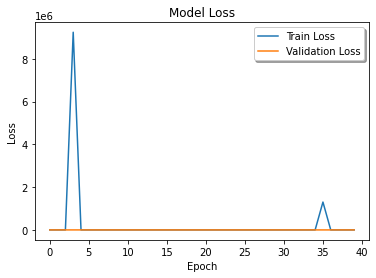

In [28]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

### Performance on Testing Data
> In this step, we have utilised the test data and made the model predict the values, to validate its performance.

In [30]:
# Predicting the prices
predicted_sales = model_lstm.predict(X_valid_series)

# # We flatten the 2 dimensional array so we can plot it with matplotlib
Y_valid = Y_valid.flatten()
predicted_sales = predicted_sales.flatten()

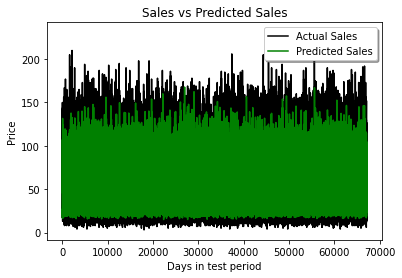

In [31]:
plt.plot(Y_valid, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend(fancybox=True, shadow=True)
plt.show()